In [1]:
%load_ext autoreload
%autoreload 2
import os
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import readResultsBaysian as rrb
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee
import numpy as np
import SR_hetro as srh
import matplotlib.pyplot as plt

In [2]:
index_offset = 0
name_suffix = "for_separate_figs"

In [3]:
#get list of all config directories. all directories in the configs directory that start with configs
def getConfigDirs(parent_dir='configs',ignore = []):
    configDirs = []
    for dir in os.listdir(parent_dir):
        if dir.startswith('config') and dir not in ignore:
            configDirs.append(os.path.join(parent_dir,dir))
    return configDirs


def get_dataSets_and_best_sims(configDirs,resultDir):
    dataSets = {}
    bestSims = {}
    time_ranges = {}
    values = {}
    current_folder = os.path.basename(os.getcwd())    
    for configDir in configDirs:
        print("At config: ", configDir)
        config = cl.read_configs(configDir)
        nsteps = int(config.get('DEFAULT', 'nsteps'))
        npeople = int(config.get('DEFAULT', 'npeople'))
        t_end = int(config.get('DEFAULT', 't_end'))
        nwalkers = int(config.get('DEFAULT', 'nwalkers'))
        nsteps = int(config.get('DEFAULT', 'nsteps'))
        time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
        time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
        data_file = config.get('DEFAULT', 'data_file')
        results_csv_file_name = config.get('DEFAULT', 'results_csv_file_name')
        hetro = config.getboolean('DEFAULT', 'hetro',fallback=False)
        external_hazard = ast.literal_eval(config.get('DEFAULT', 'external_hazard'))
        #all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
        # (remove everything before the current folder name)
        data_file = data_file.split(current_folder)[-1]
        #remove the first / from the paths
        data_file = data_file[1:]
        key = results_csv_file_name.split('.')[0]

        if key =='Mice_F':
            bandwidth = 13
        else:
            bandwidth = 3
        ds = dtds.dsFromFile(data_file,bandwidth=bandwidth)
        if resultDir[configDir].endswith('.csv'):
            theta = rrb.getTheta(resultDir[configDir])
            value = rrb.getParams(resultDir[configDir],[9])
        else:
            theta = rrb.getTheta(os.path.join(resultDir[configDir],results_csv_file_name))
            value = rrb.getParams(os.path.join(resultDir[configDir],results_csv_file_name),[9])
        if hetro:
            external_hazard =rrb.getParams(os.path.join(resultDir[configDir],results_csv_file_name),['ExtH'])
        sim = srh.getSrHetro(theta,nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=external_hazard, parallel=True,hetro=hetro,bandwidth=bandwidth)
        dataSets[key] = ds
        bestSims[key] = sim
        time_ranges[key] = time_range
        values[key] = value


    return dataSets, bestSims, time_ranges, values

In [4]:
# configDirs = getConfigDirs(ignore=['configs_drosophila_195and217'])
configDirs = [  'configs/configs_ecoli',
                'configs/configs_yeast',
                'configs/configs_celegance',
                'configs/DROSOPHILA/configs_drosophila_441',
                'configs/DROSOPHILA/configs_drosophila_217',
                'configs/DROSOPHILA/configs_drosophila_707',
                'configs/DROSOPHILA/configs_drosophila_853',
                'configs/configs_mice_F','configs/configs_mice_M2',
                'configs/configs_cats_BPH',
                'configs/DOGS/configs_Labrador_vetCompass','configs/DOGS/configs_Staffy_vetCompass','configs/DOGS/configs_Jack_Russell_vetCompass','configs/DOGS/configs_German_Shepherd_vetCompass',
                'configs/HUMANS/configs_Denmark_F_1900','configs/HUMANS/configs_Denmark_M_1900']
resultsDir = {  'configs/configs_ecoli':'results_csvs',
                'configs/configs_yeast':'results_csvs/Yeast.csv',
                'configs/configs_celegance':'results_csvs',
                'configs/DROSOPHILA/configs_drosophila_441':'results_csvs/DROSOPHILA/drosophila_441.csv',
                'configs/DROSOPHILA/configs_drosophila_217':'results_csvs/DROSOPHILA/drosophila_217.csv',
                'configs/DROSOPHILA/configs_drosophila_707':'results_csvs/DROSOPHILA/drosophila_707.csv',
                'configs/DROSOPHILA/configs_drosophila_853':'results_csvs/DROSOPHILA/drosophila_853.csv',
                'configs/configs_mice_F':'results_csvs',
                'configs/configs_mice_M2':'results_csvs',
                'configs/configs_cats_BPH':'results_csvs/cats_BPH.csv',
                'configs/DOGS/configs_Labrador_vetCompass':'results_csvs/DOGS/Labrador_vetCompass.csv',
                'configs/DOGS/configs_Staffy_vetCompass':'results_csvs/DOGS/Staffy_vetCompass.csv',
                'configs/DOGS/configs_Jack_Russell_vetCompass':'results_csvs/DOGS/Jack_Russell_vetCompass.csv',
                'configs/DOGS/configs_German_Shepherd_vetCompass':'results_csvs/DOGS/German_Shepherd_vetCompass.csv',
                'configs/HUMANS/configs_Denmark_M_1900':'results_csvs/HUMANS',
                'configs/HUMANS/configs_Denmark_F_1900':'results_csvs/HUMANS'}
dataSets, bestSims, time_ranges, values = get_dataSets_and_best_sims(configDirs, resultsDir)

At config:  configs/configs_ecoli
At config:  configs/configs_yeast
At config:  configs/configs_celegance
At config:  configs/DROSOPHILA/configs_drosophila_441
At config:  configs/DROSOPHILA/configs_drosophila_217
At config:  configs/DROSOPHILA/configs_drosophila_707
At config:  configs/DROSOPHILA/configs_drosophila_853
At config:  configs/configs_mice_F
At config:  configs/configs_mice_M2
At config:  configs/configs_cats_BPH
At config:  configs/DOGS/configs_Labrador_vetCompass
At config:  configs/DOGS/configs_Staffy_vetCompass
At config:  configs/DOGS/configs_Jack_Russell_vetCompass
At config:  configs/DOGS/configs_German_Shepherd_vetCompass
At config:  configs/HUMANS/configs_Denmark_F_1900
At config:  configs/HUMANS/configs_Denmark_M_1900


In [5]:
print(dataSets.keys())

dict_keys(['Ecoli', 'Yeast', 'celegance', 'drosophila_441', 'drosophila_217', 'drosophila_707', 'drosophila_853', 'Mice_F', 'Mice2_M', 'catsBPH', 'Labrador_vetCompass', 'Staffy_vetCompass_results', 'Jack_Russell_results', 'German_Shepherd_results', 'Denmark_F_1900_hetro', 'Denmark_M_1900'])


/var/folders/pr/hngn4yrn3v3gt3069stbsfqh0000gp/T/ipykernel_63977/1891989473.py:116: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('plasma', len(dataSets.keys()))


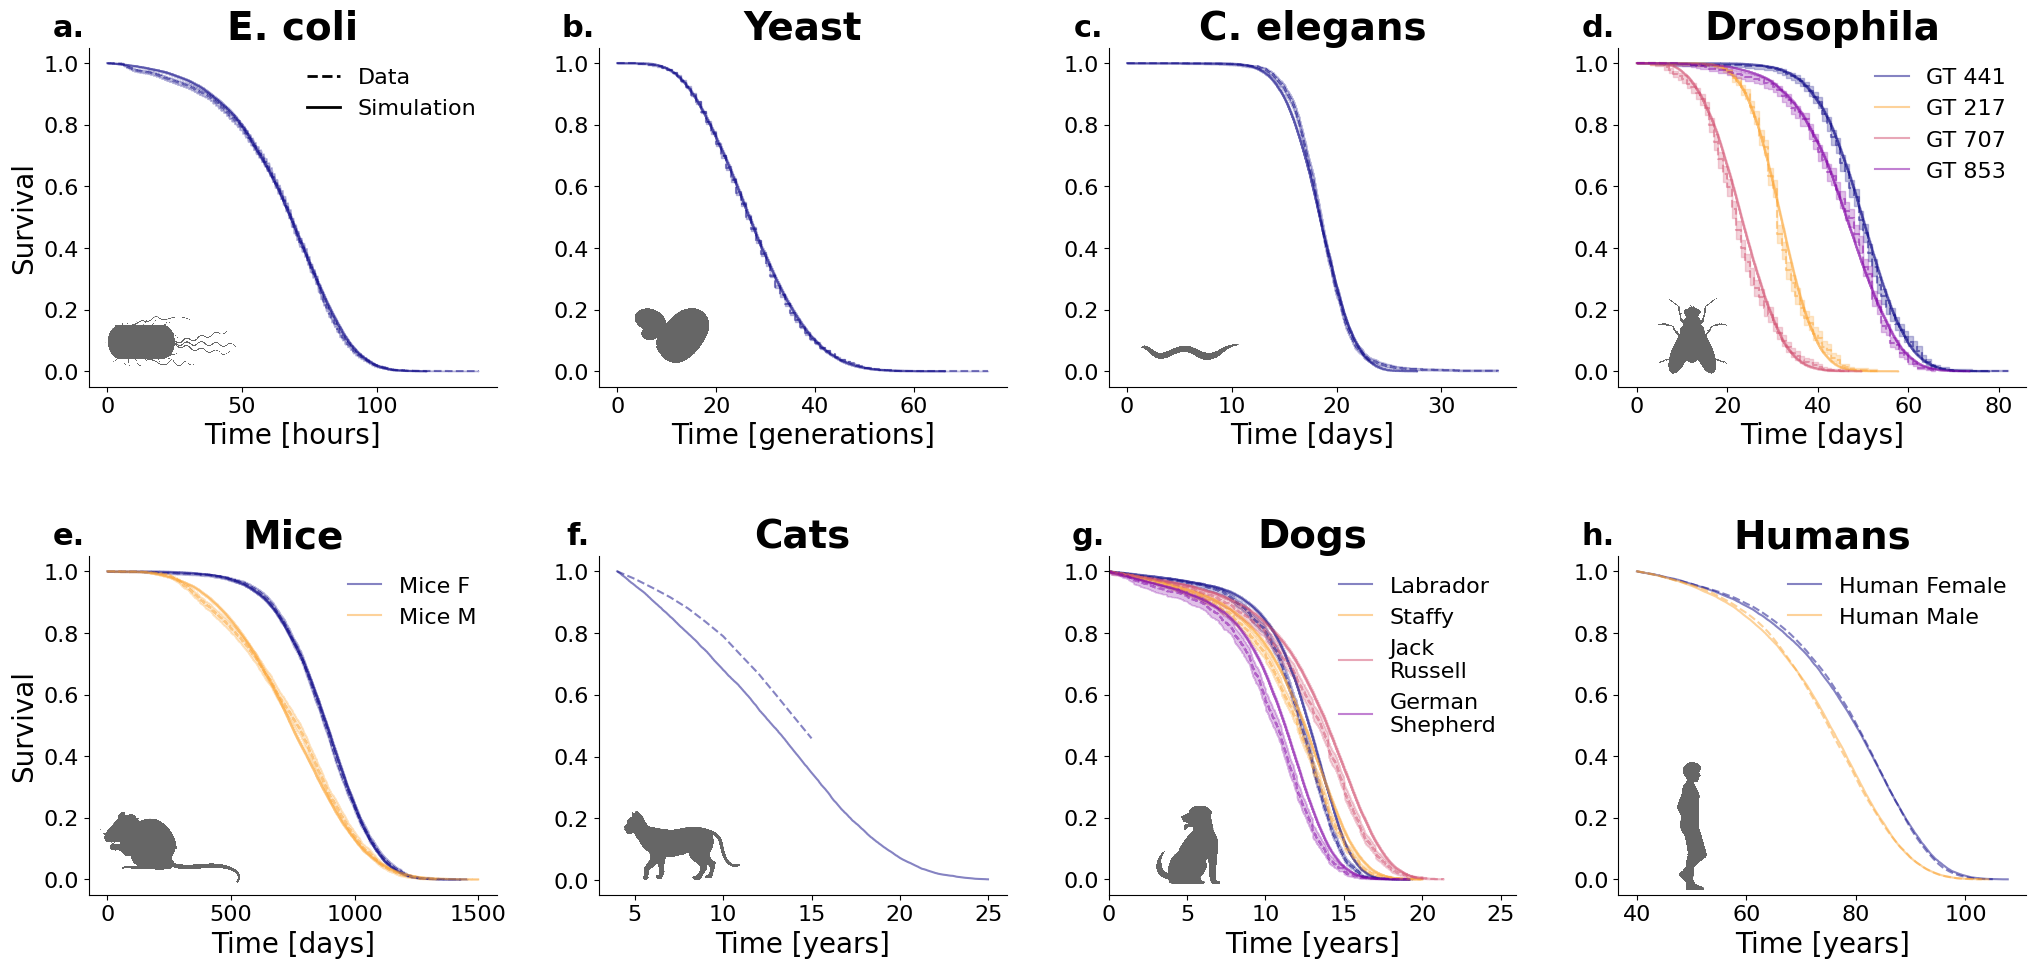

In [16]:
#plot a 4 by 2 grid of the best fits of survival and data where each panel is a different organizm, we have 8 organisms: ecoli, yeast, celegance, drosophila, mice, cats, dogs, humans:
fig, axs = plt.subplots(2, 4, figsize=(25, 11))
axs = axs.ravel()
#add padding between the plots, in the top left corner of each panel add a  number of the panel
fig.subplots_adjust(hspace=0.5, wspace=0.25)
#add numbering to the plots
for i, ax in enumerate(axs):
    ax.text(-0.05, 1.06, f'{chr(97 + index_offset + i)}.', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=22, weight='bold', color='black')



labels = {'Ecoli':'E. coli',
           'Yeast': 'Yeast',
           'celegance': 'C. elegans',
           'drosophila_441': 'GT 441',
           'drosophila_217': 'GT 217',
           'drosophila_707': 'GT 707',
           'drosophila_853': 'GT 853',
           'Mice_F': 'Mice F',
           'Mice2_M': 'Mice M',
           'catsBPH': 'Cats',
           'Labrador_vetCompass': 'Labrador',
           'Staffy_vetCompass_results': 'Staffy',
           'Jack_Russell_results': 'Jack\nRussell',
           'German_Shepherd_results': 'German\nShepherd',
           'Denmark_M_1900': 'Human Male',
           'Denmark_F_1900_hetro': 'Human Female'
}

species = {'Ecoli':'E. coli',
           'Yeast': 'Yeast',
           'celegance': 'C. elegans',
           'drosophila_441': 'Drosophila Melanogaster',
           'drosophila_217': 'Drosophila Melanogaster',
           'drosophila_707': 'Drosophila Melanogaster',
           'drosophila_853': 'Drosophila Melanogaster',
           'Mice_F': 'Mice',
           'Mice2_M': 'Mice',
           'catsBPH': 'Cats',
           'Labrador_vetCompass': 'Dogs',
           'Staffy_vetCompass_results': 'Dogs',
           'Jack_Russell_results': 'Dogs',
           'German_Shepherd_results': 'Dogs',
           'Denmark_M_1900': 'Humans',
           'Denmark_F_1900_hetro': 'Humans'
}

ax_dict = {
    'E. coli': axs[0],
    'Yeast': axs[1],
    'C. elegans': axs[2],
    'Drosophila Melanogaster': axs[3],
    'Mice': axs[4],
    'Cats': axs[5],
    'Dogs': axs[6],
    'Humans': axs[7]
}

times_dict = {
    'E. coli': 'hours',
    'Yeast': 'generations',
    'C. elegans': 'days',
    'Drosophila Melanogaster': 'days',
    'Mice': 'days',
    'Cats': 'years',
    'Dogs': 'years',
    'Humans': 'years'
}

img_dict = {
    'E. coli': 'silhouetts/ecoli.jpeg',
    'Yeast': 'silhouetts/yeast.jpeg',
    'C. elegans': 'silhouetts/celegance.jpeg',
    'Drosophila Melanogaster': 'silhouetts/fly silhouette.jpeg',
    'Mice': 'silhouetts/mice.jpg',
    'Cats': 'silhouetts/cat silhouette.jpeg',
    'Dogs': 'silhouetts/Labrador.jpg',
    'Humans': 'silhouetts/man silhouette.jpeg'
}

zoom_dict = {
    'E. coli': 0.025,
    'Yeast': 0.02,
    'C. elegans': 0.025,
    'Drosophila Melanogaster': 0.021,
    'Mice': 0.03,
    'Cats': 0.03,
    'Dogs': 0.03,
    'Humans': 0.03
}

offset_dict = {
    'E. coli': [0.2,0.13],
    'Yeast': [0.18,0.15],
    'C. elegans': [0.2,0.1],
    'Drosophila Melanogaster': [0.18,0.15],
    'Mice': [0.2,0.14],
    'Cats': [0.2,0.14],
    'Dogs': [0.19,0.15],
    'Humans': [0.18,0.2]
}

import readResultsBaysian as rrb
from matplotlib import image as mpimg
from matplotlib import offsetbox


#Plot survival of all the data sets and best fits. Datsets and best fits with the same spicies given by the species dictionary is the same should be plotted on the same panel.
#the title of each plot should be the species name given by the species dictionary, and legend labels given by the labels dictionary
#define an axis font dictionary, legned font dictionary, and a title font dictionary.
axis_font = {'size':'20'}
legend_font = {'size':'16'}
title_font = {'size':'28','weight':'bold'}
ticks_font = {'size':'16'}

colormap = plt.cm.get_cmap('plasma', len(dataSets.keys()))

for i, key in enumerate(dataSets.keys()):
    ax = ax_dict[species[key]]
    #get number of plots already on the axis
    n = len(ax.lines)
    color = colormap(n*30 % colormap.N)
    time_range = time_ranges[key]
    dataSets[key].plotSurvival(ax, time_range=time_range,label='', linewidth=1.5, ls='--', color=color, alpha=0.5)
    bestSims[key].plotSurvival(ax, time_range=time_range, label=labels[key], linewidth=1.5, color=color, alpha=0.5)
    if species[key]=='Dogs':
        ax.set_xlim(0, 26)
    if species[key]=='Drosophila Melanogaster':
        ax.set_title('Drosophila', **title_font)
    else:
        ax.set_title(species[key], **title_font)
    ax.set_xlabel('Time '+f'[{times_dict[species[key]]}]', **axis_font)
    #set ticks font
    ax.tick_params(axis='both', which='major', labelsize=16)


for i, key in enumerate(ax_dict.keys()):
    ax = axs[i]
    n = len(ax.lines)
    handles, labels = ax.get_legend_handles_labels()
    #read image path from img_dict and plot it in the top right corner of the plot. make all images same size
    img = mpimg.imread(img_dict[key])
    offset = offset_dict[key]
    x = offset[0]*(ax.get_xlim()[1]-ax.get_xlim()[0])+ax.get_xlim()[0]
    y = offset[1]*(ax.get_ylim()[1]-ax.get_ylim()[0])+ax.get_ylim()[0]
   
    rrb.add_image_marker(ax, img, x, y, zoom=zoom_dict[key])

    if i==0:
        #remove the first legend entry
        handles = handles[1:]
        handles.append(plt.Line2D([0], [0], color='black', lw=2, ls='--', label='Data'))
        handles.append(plt.Line2D([0], [0], color='black', lw=2, label='Simulation'))
        ax.legend(handles=handles, frameon=False, loc='upper right', prop=legend_font, handlelength=1.5)
    elif n > 2:
        ax.legend(handles=handles,frameon=False,loc ='upper right', prop=legend_font, handlelength=1.5)
    else:
        #remove legend
        ax.legend([],[], frameon=False)

    if i in [0,4]:
        ax.set_ylabel('Survival', **axis_font)
    else:
        ax.set_ylabel('')
    
# plt.tight_layout()

#save the figure
# plt.savefig('survival_plots.png', dpi=300)

plt.savefig(f'plots/All fits_{name_suffix}.pdf', format='pdf', dpi=1200)






Yeast
celegance
drosophila_441
Mice_F
Ecoli
Labrador_vetCompass
catsBPH
Denmark_M_1900


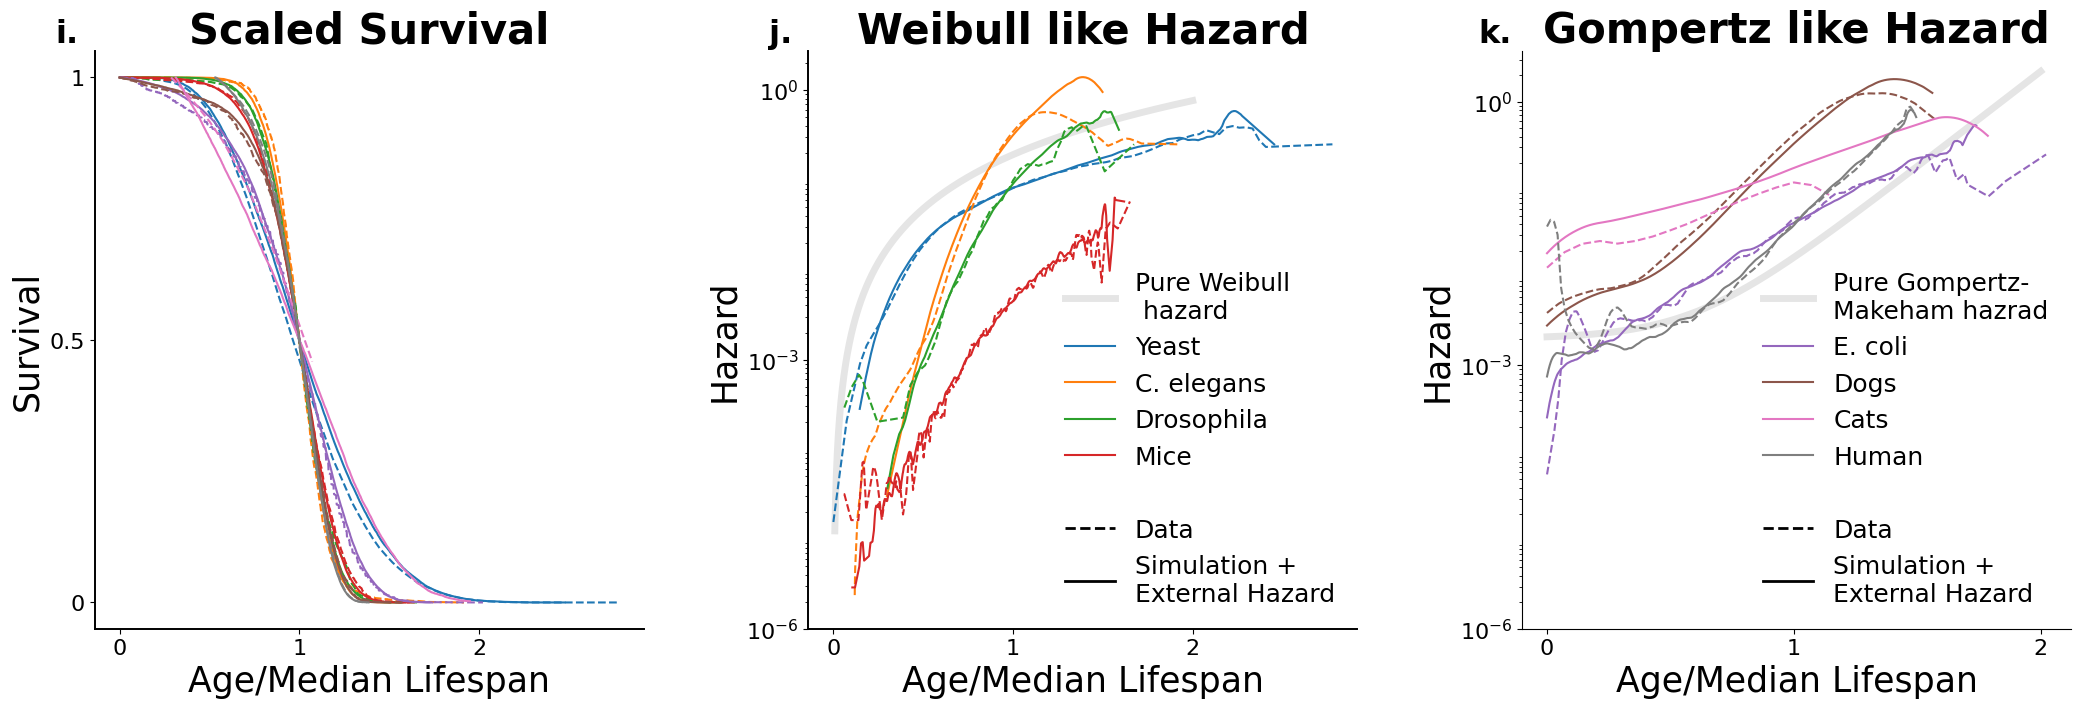

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(17*1.5, 7.5))
#add horizontal padding between the plots
fig.subplots_adjust(wspace=0.3)
colormap  = plt.get_cmap('tab10')

labels = {'Ecoli':'E. coli',
          'Yeast': 'Yeast',
           'celegance': 'C. elegans',
             'drosophila_441': 'Drosophila',
               'Mice_F': 'Mice',
                 'Labrador_vetCompass': 'Dogs',
                  'catsBPH': 'Cats',
                   'Denmark_M_1900': 'Human'
                   }


ref_t = np.linspace(0,2,1000)
import utils
ref_props ={'color':'black','lw':5,'ls':'-','alpha':0.1}
weibull = utils.weibull_hazard(ref_t,shape=3,scale=2.5)
gompertz = utils.gompertz_makeham_hazard(ref_t,intercept=1e-4,slope=5,makeham=2e-3)
ax[1].plot(ref_t[weibull>1e-5],weibull[weibull>1e-5],label='Pure Weibull\n hazard',**ref_props)
ax[2].plot(ref_t,gompertz,label='Pure Gompertz-\nMakeham hazrad', **ref_props)

i=0
for key in ['Yeast','celegance', 'drosophila_441', 'Mice_F', ]:
    print(key)
    ds = dataSets[key]
    sim = bestSims[key]
    time_range = time_ranges[key]
    value = values[key]
    

    ds.plotScaledSurvival(ax=ax[0], time_range=time_range, label='', ls='--', color=colormap(i),CI=False)
    ds.plotScaledHazard(ax=ax[1], label='', ls='--', color=colormap(i))
    scale= ds.getMedianLifetime()
    sim.plotScaledSurvival(ax=ax[0], time_range=time_range, label=labels[key], color=colormap(i),CI=False)
    sim.plotScaledHazard(ax=ax[1],scale=scale, label=labels[key], color=colormap(i))
    i+=1

for key in ['Ecoli', 'Labrador_vetCompass','catsBPH', 'Denmark_M_1900']:
    print(key)
    ds = dataSets[key]
    sim = bestSims[key]
    time_range = time_ranges[key]
    value = values[key]
    

    ds.plotScaledSurvival(ax=ax[0], time_range=time_range, label='', ls='--', color=colormap(i),CI=False)
    ds.plotScaledHazard(ax=ax[2], label='', ls='--', color=colormap(i))
    scale= ds.getMedianLifetime()
    sim.plotScaledSurvival(ax=ax[0], time_range=time_range, label=labels[key], color=colormap(i),CI=False)
    sim.plotScaledHazard(ax=ax[2],scale=scale, label=labels[key], color=colormap(i))
    i+=1

legend_font = {'size':'18'}
axis_font = {'size':'25'}
ticks_font = {'size':'16'}
title_font = {'size':'30','weight':'bold'}


#put legend on bottom right of the right plot. Add to legend shhowinf full line is simulation and dashed line is data
handles, labels = ax[2].get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='white', lw=0, label=''))
handles.append(plt.Line2D([0], [0], color='black', lw=2, ls='--', label='Data'))
handles.append(plt.Line2D([0], [0], color='black', lw=2, label='Simulation +\nExternal Hazard'))
ax[2].legend(handles=handles, loc='lower right', frameon=False, prop=legend_font)

handles, labels = ax[1].get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='white', lw=0, label=''))
handles.append(plt.Line2D([0], [0], color='black', lw=2, ls='--', label='Data'))
handles.append(plt.Line2D([0], [0], color='black', lw=2, label='Simulation +\nExternal Hazard'))
ax[1].legend(handles=handles, loc='lower right', frameon=False, prop=legend_font)



#have just three ticks on each axis, add axis labels
ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels([0,1,2], **ticks_font)
ax[0].set_yticks([0,0.5,1])
ax[0].set_yticklabels([0,0.5,1], **ticks_font)
ax[0].set_xlabel('Age/Median Lifespan', **axis_font)
ax[0].set_ylabel('Survival', **axis_font)
ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels([0,1,2], **ticks_font)
ax[1].set_yticks([1e-6,1e-3,1])
ax[1].set_yticklabels(['$10^{{-6}}$', '$10^{{-3}}$', '$10^{{0}}$'], **ticks_font)
ax[1].set_xlabel('Age/Median Lifespan', **axis_font)
ax[1].set_ylabel('Hazard', **axis_font)
ax[2].set_xticks([0,1,2])
ax[2].set_xticklabels([0,1,2], **ticks_font)
ax[2].set_yticks([1e-6,1e-3,1])
ax[2].set_yticklabels(['$10^{{-6}}$', '$10^{{-3}}$', '$10^{{0}}$'], **ticks_font)
ax[2].set_xlabel('Age/Median Lifespan', **axis_font)
ax[2].set_ylabel('Hazard', **axis_font)

#make axis lines thicker
alw = 1.4
for axis in ['top','bottom','left','right']:
  ax[0].spines[axis].set_linewidth(alw)
  ax[1].spines[axis].set_linewidth(alw)

ax[0].text(-0.05, 1.03, f'{chr(97 +index_offset+ 8)}.', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=23, weight='bold')
ax[0].text(-0.05, 1.03, f'{chr(97 +index_offset+ 9)}.', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=23, weight='bold')
ax[0].text(-0.05, 1.03, f'{chr(97 +index_offset+ 10)}.', horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes, fontsize=23, weight='bold')


ax[0].set_title('Scaled Survival', **title_font)
ax[1].set_title('Weibull like Hazard', **title_font)
ax[2].set_title('Gompertz like Hazard', **title_font)



# #add super title
# fig.suptitle('Model fits a wide range of survival data', fontsize=28,weight='bold')

#save figure as svg
plt.savefig(f'plots/model_fits_different_organisms_for_paper_{name_suffix}.pdf', format='pdf', dpi=1200)


In [5]:
time_ranges_fits={'Ecoli':None,
           'Yeast': None,
           'celegance': [5,23],
           'drosophila_441': [5,100],
           'drosophila_217': [5,100],
           'drosophila_707': [5,40],
           'drosophila_853': [5,100],
           'Mice_F': None,
           'Mice2_M': None,
           'catsBPH': [4,100],
           'Labrador_vetCompass': [4,18],
           'Staffy_vetCompass_results': [4,100],
           'Jack_Russell_results': [4,18],
           'German_Shepherd_results': [4,100],
           'Denmark_M_1900': [40,120],
           'Denmark_F_1900_hetro': [40,120]
}

Confidence interval not available for this dataset
Confidence interval not available for this dataset.
Confidence interval not available for this dataset
Confidence interval not available for this dataset.
Confidence interval not available for this dataset
Confidence interval not available for this dataset.
Confidence interval not available for this dataset
Confidence interval not available for this dataset.
Confidence interval not available for this dataset
Confidence interval not available for this dataset.
Confidence interval not available for this dataset
Confidence interval not available for this dataset.
Confidence interval not available for this dataset
Confidence interval not available for this dataset.
Confidence interval not available for this dataset
Confidence interval not available for this dataset.
Confidence interval not available for this dataset
Confidence interval not available for this dataset.
Confidence interval not available for this dataset
Confidence interval no

,Key,Weibull BIC,Gompertz-Makeham BIC,Difference,Better Model,Weibull Params,Gompertz-Makeham Params
0,Ecoli,42485.701103,41819.053938,666.647166,gompertz,"{'lambda_': 71.70982124243385, 'rho_': 3.55365...","{'eta': 0.0010062737916602085, 'alfa': 0.05388..."
1,Yeast,197202.063066,201804.057946,4601.994879,Weibull,"{'lambda_': 30.352710020630667, 'rho_': 3.0975...","{'eta': 0.005842981970788676, 'alfa': 0.088404..."
2,celegance,9952.753550,10023.768143,71.014593,Weibull,"{'lambda_': 19.21063098277379, 'rho_': 9.21727...","{'eta': 3.4781064800038014e-05, 'alfa': 0.4942..."
3,drosophila_441,8756.451852,8851.227895,94.776043,Weibull,"{'lambda_': 52.63319958603063, 'rho_': 6.44908...","{'eta': 0.00019382795957829628, 'alfa': 0.1207..."
4,drosophila_217,7291.844352,7482.219880,190.375528,Weibull,"{'lambda_': 34.24566165538278, 'rho_': 5.46161...","{'eta': 0.0007295431148205099, 'alfa': 0.15367..."
5,drosophila_707,7397.055700,7538.580563,141.524862,Weibull,"{'lambda_': 24.712806874126493, 'rho_': 3.4757...","{'eta': 0.004488002612708662, 'alfa': 0.134300..."
6,drosophila_853,9026.809100,8963.291519,63.517581,gompertz,"{'lambda_': 49.12697044807004, 'rho_': 5.48862...","{'eta': 0.0003000574234319287, 'alfa': 0.11996..."
7,Mice_F,46820.636556,57299.334046,10478.697490,Weibull,"{'lambda_': 941.8826060914805, 'rho_': 5.74095...","{'eta': 1.3233247447776295e-09, 'alfa': 0.0153..."
8,Mice2_M,36204.145428,50550.111204,14345.965776,Weibull,"{'lambda_': 824.3172607198929, 'rho_': 3.51868...","{'eta': 1.5453198742880073e-09, 'alfa': 0.0158..."
9,catsBPH,149383.439068,150323.382948,939.943879,Weibull,"{'lambda_': 16.370058311839564, 'rho_': 3.0150...","{'eta': 0.005097032467792161, 'alfa': 0.238970..."


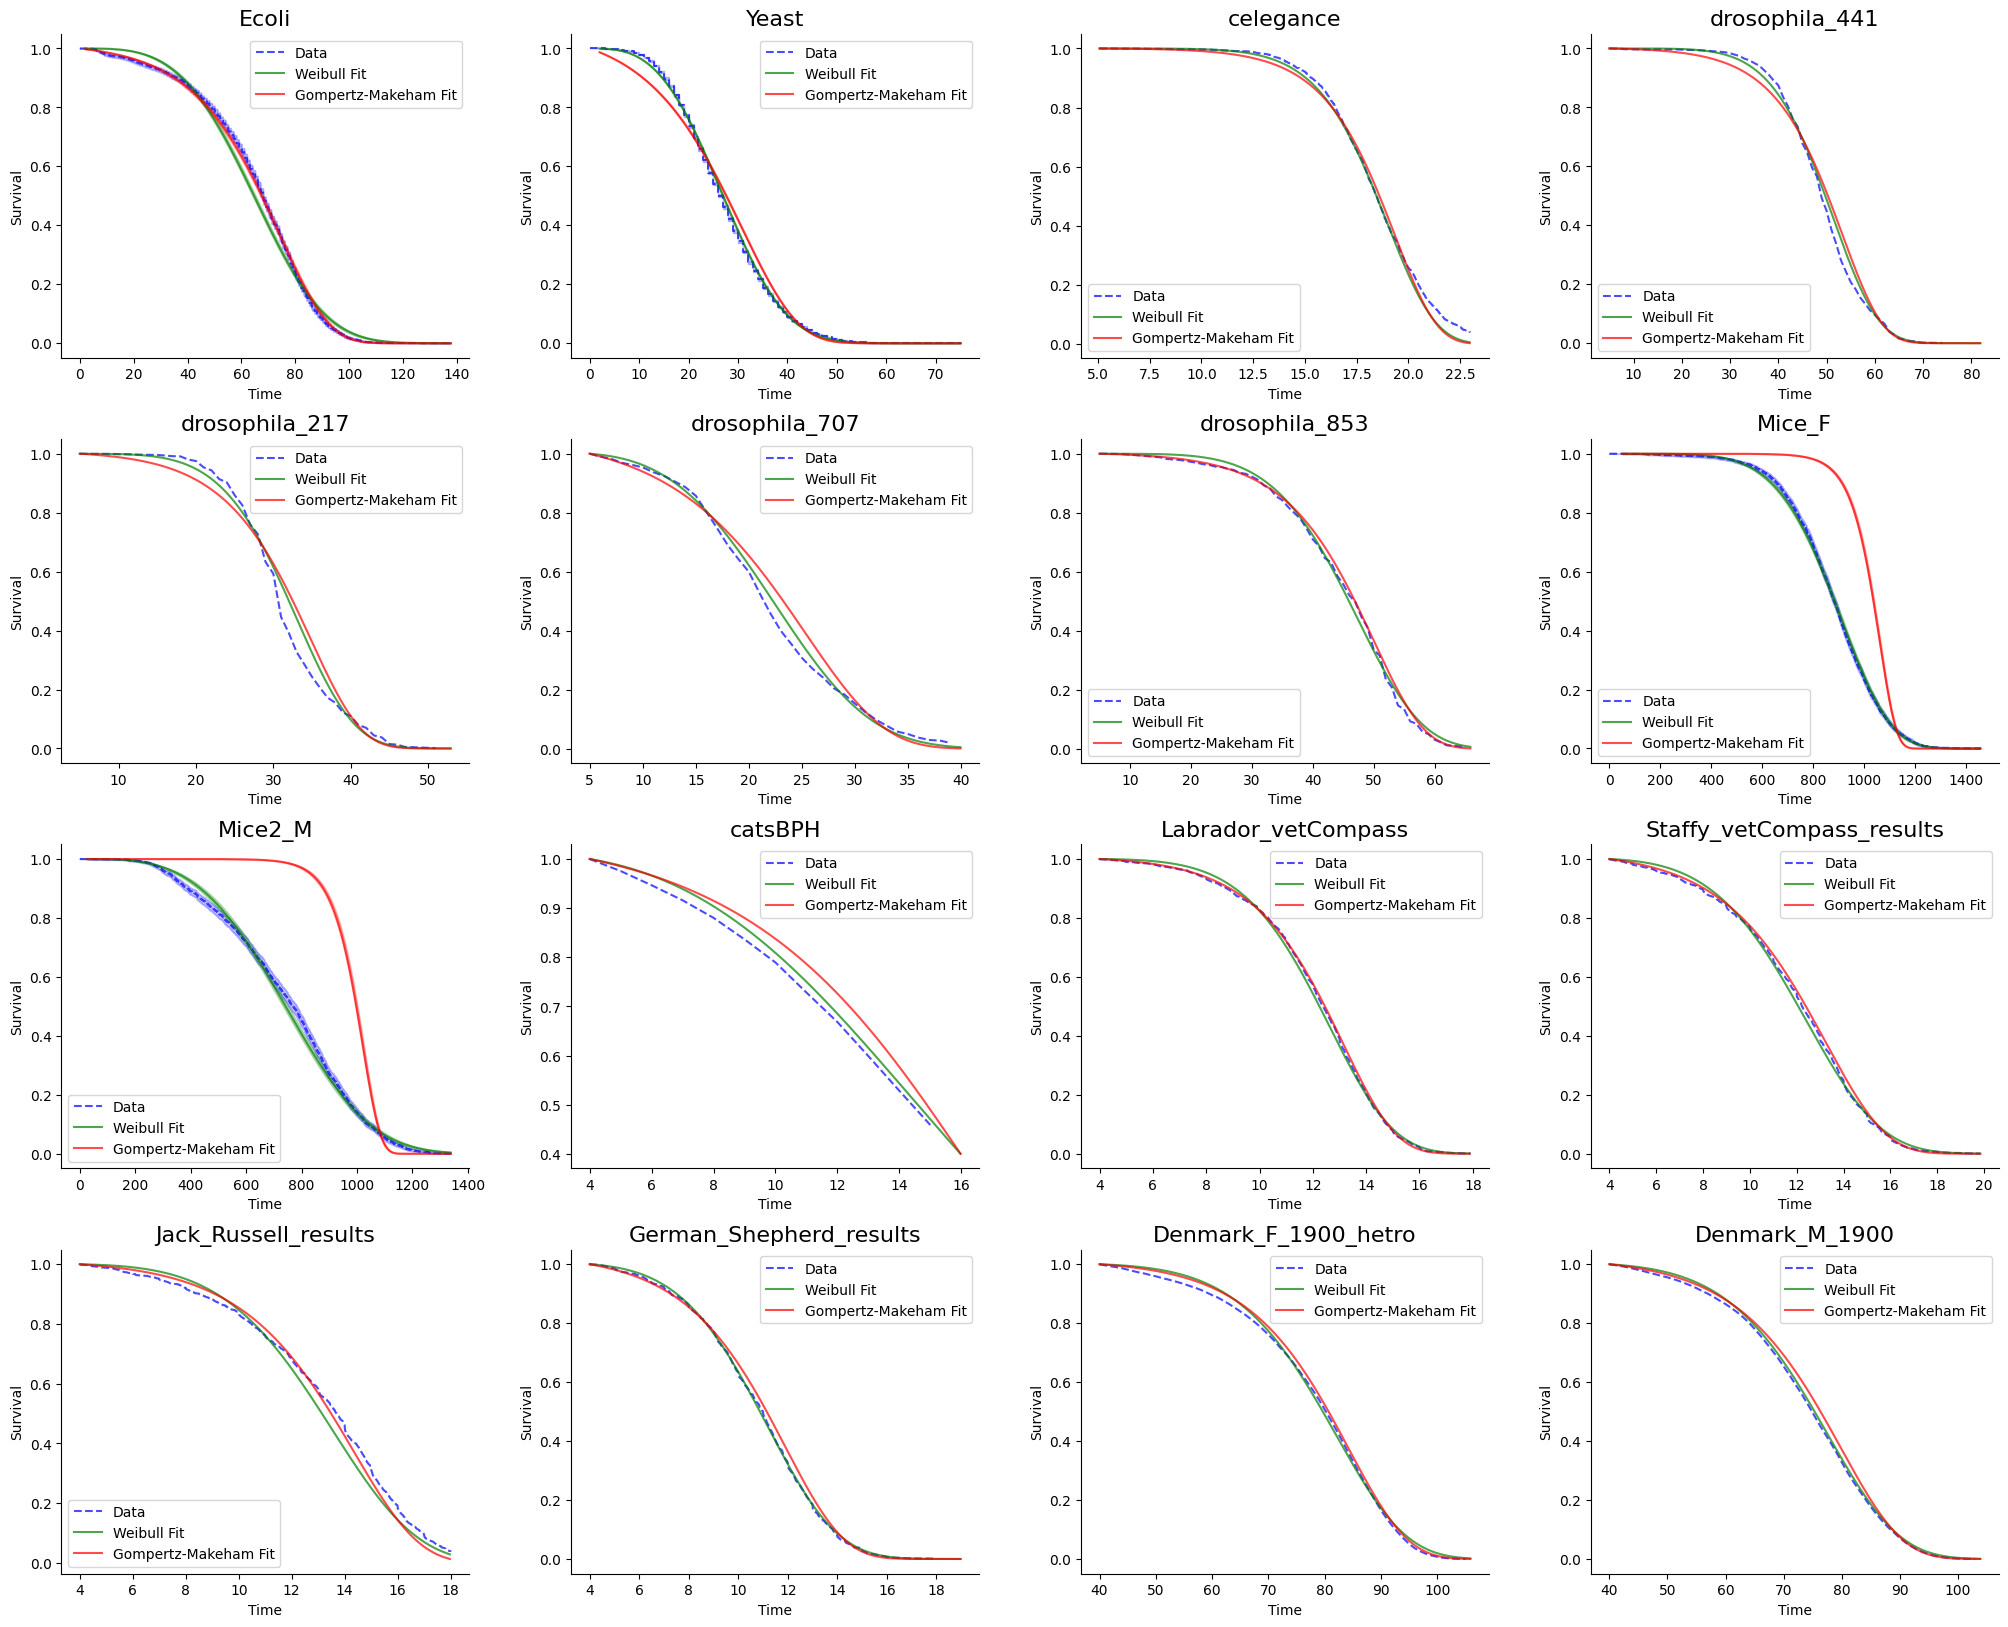

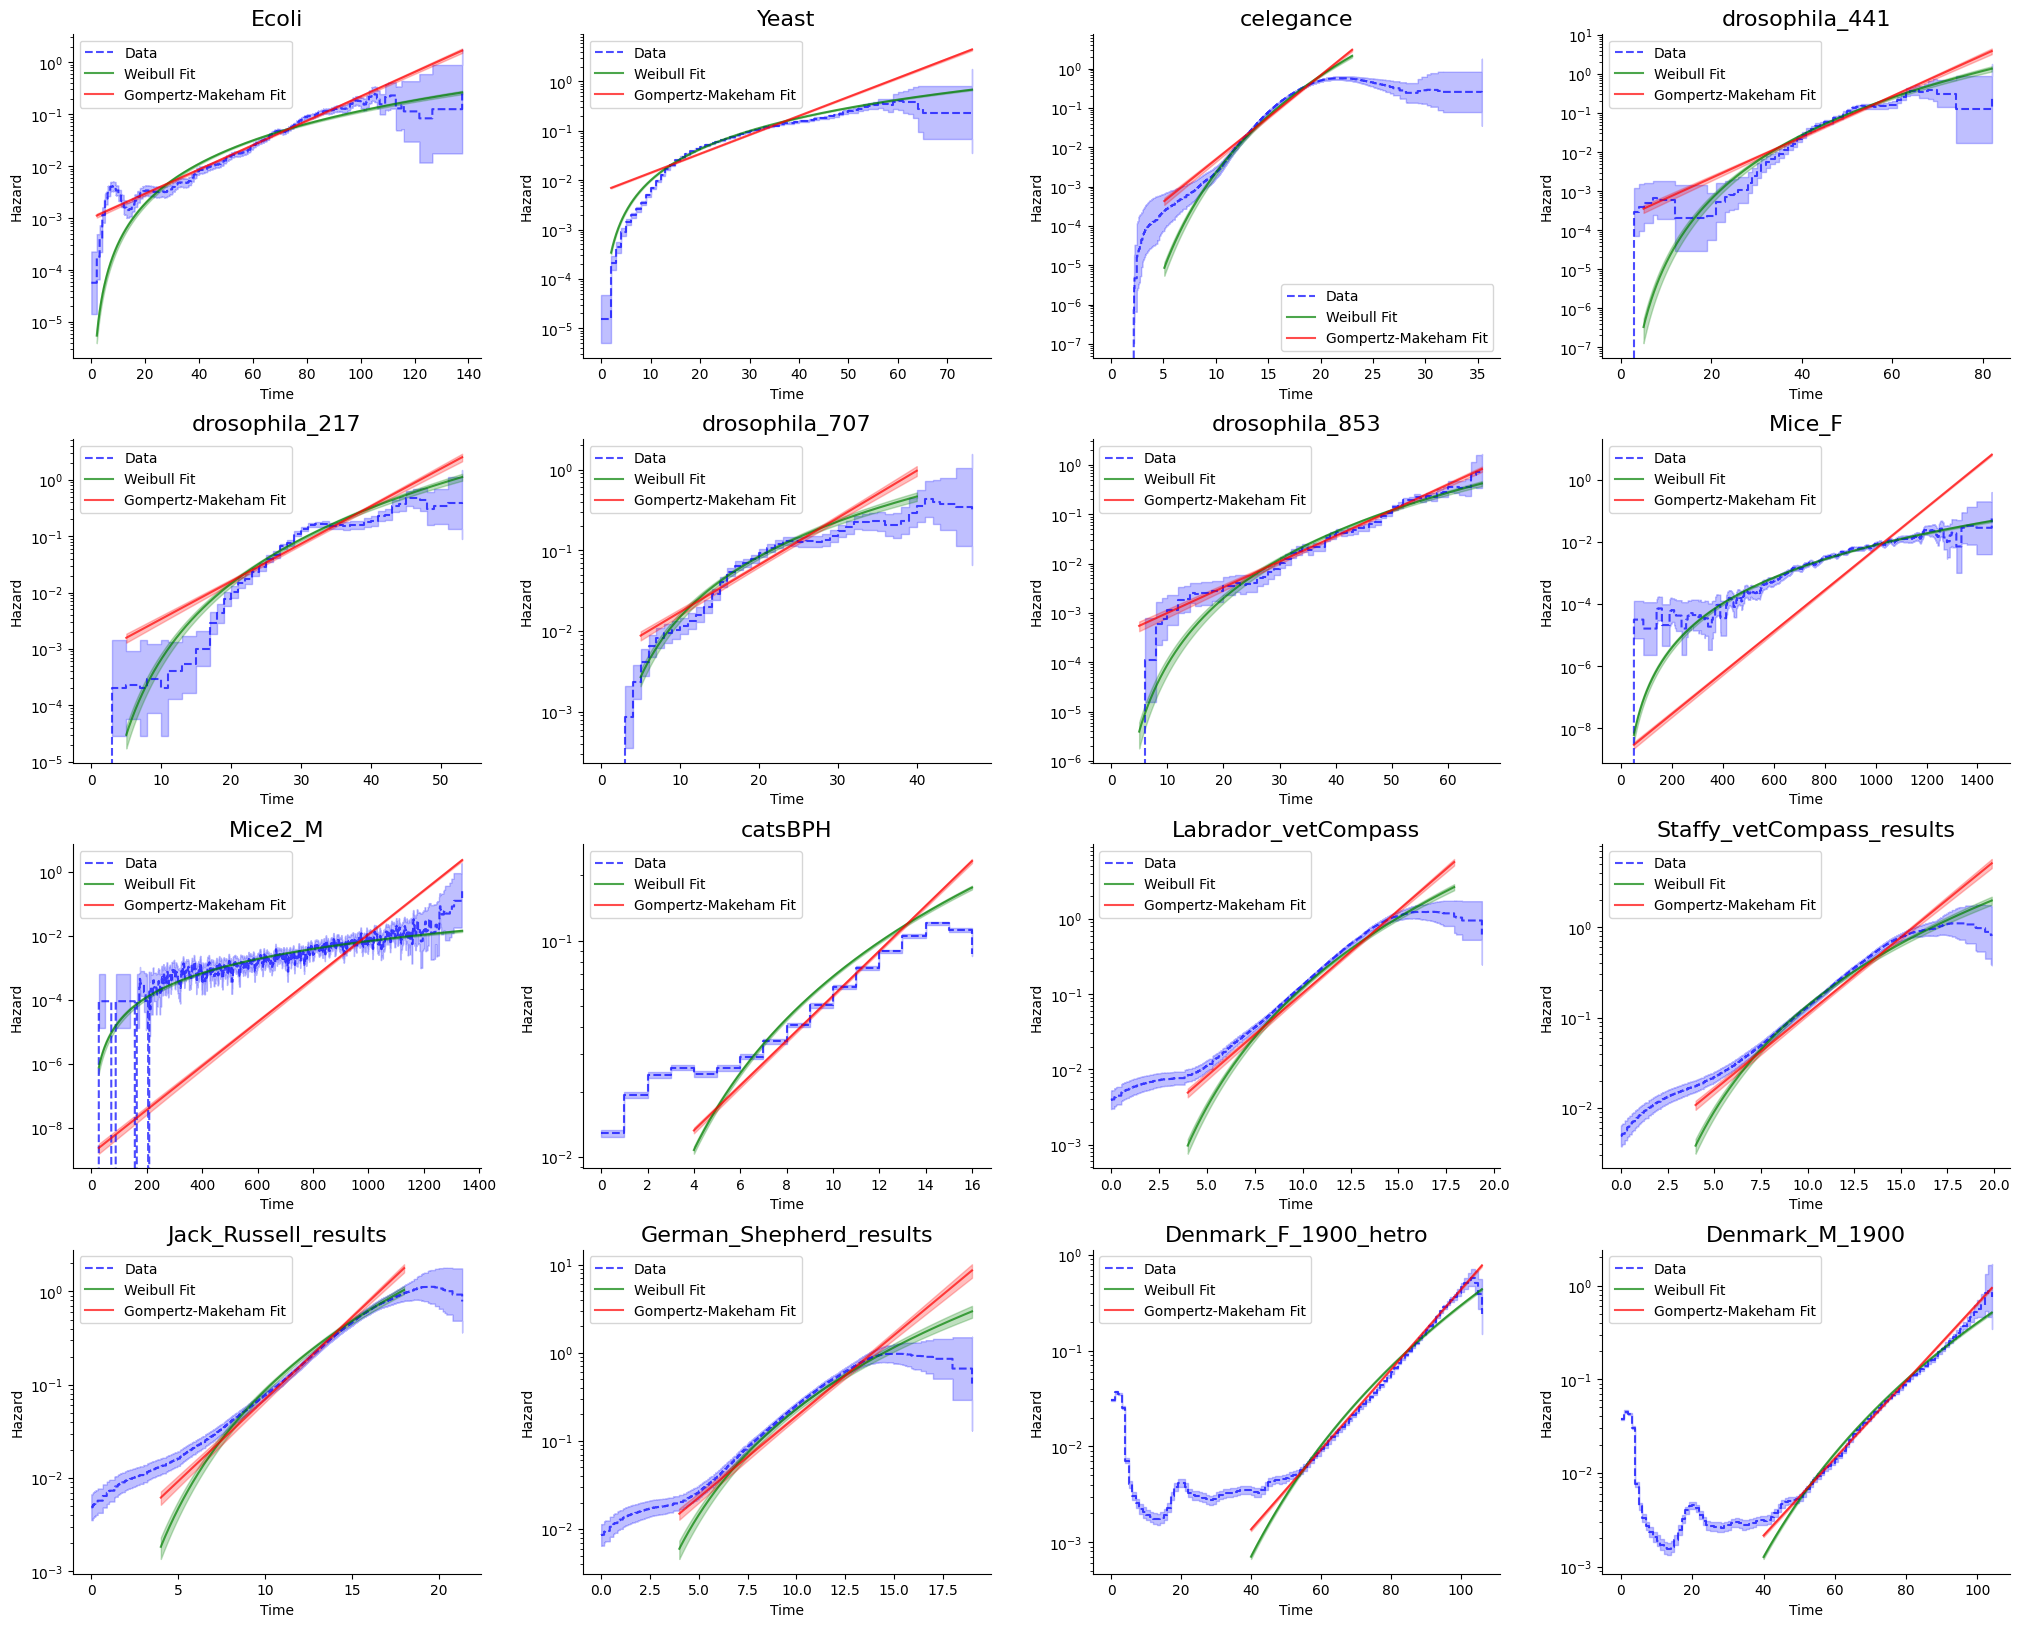

In [8]:
import weibullFitter as wft
import makhamGompertzFitter as mgf
import pandas as pd
wfs  = {}
gmfs = {}
for key, value in dataSets.items():
    time_range = time_ranges_fits[key]
    #fit weibull and gompertz makeham to the data within the time range
    death_times = value.death_times.copy()
    events = value.events.copy()
    #remove all death times and events that are not in the time range
    if time_range is not None:
        time_range = np.array(time_range).copy()
        events = events[(death_times >= time_range[0]) & (death_times <= time_range[1])]
        death_times = death_times[(death_times >= time_range[0]) & (death_times <= time_range[1])]
    wfs[key] = wft.WeibullFitter(death_times,events)
    gmfs[key] = mgf.GompertzMakehamFitter(death_times,events)

#for each data set, plot the dataset and the fitted weibull and gompertz makeham distributions. thats len(dataSets) separate subplots
fig, axs = plt.subplots(4, 4, figsize=(25, 20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.25, wspace=0.25)
for i, (key, dataset) in enumerate(dataSets.items()):
    ax = axs[i]
    time_range = time_ranges_fits[key]
    dataset.plotSurvival(ax=ax,time_range=time_range, label='Data', ls='--', color='blue', alpha=0.7)
    wfs[key].plotSurvival(ax=ax,time_range=time_range, label='Weibull Fit', color='green', alpha=0.7)
    gmfs[key].plotSurvival(ax=ax,time_range=time_range, label='Gompertz-Makeham Fit', color='red', alpha=0.7)
    ax.set_title(f'{key}', fontsize=16)
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Survival')

#for each data set, plot the dataset and the fitted weibull and gompertz makeham distributions. thats len(dataSets) separate subplots
fig, axs = plt.subplots(4, 4, figsize=(25, 20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.25, wspace=0.25)
for i, (key, dataset) in enumerate(dataSets.items()):
    ax = axs[i]
    dataset.plotHazard(ax=ax, label='Data', ls='--', color='blue', alpha=0.7)
    wfs[key].plotHazard(ax=ax, label='Weibull Fit', color='green', alpha=0.7)
    gmfs[key].plotHazard(ax=ax, label='Gompertz-Makeham Fit', color='red', alpha=0.7)
    ax.set_title(f'{key}', fontsize=16)
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Hazard')
    ax.set_yscale('log')

#print table of the key, and the bic value for the weibull and gompertz makeham fits, so the coluemn names are 'Key', 'Weibull BIC', 'Gompertz-Makeham BIC'
#to access the bic use the BIC() method of the fitter
# Create a list to store the table data
table_data = []

# Populate the table data with keys, BIC values, and the better model
for key in dataSets.keys():
    weibull_bic = wfs[key].BIC()
    weibull_params = wfs[key].getParams()
    
    gompertz_bic = gmfs[key].BIC()
    gompertz_params = gmfs[key].getParams()
    
    difference = np.abs(weibull_bic - gompertz_bic)
    better_model = "gompertz" if gompertz_bic < weibull_bic else "Weibull"
    table_data.append({
        'Key': key, 
        'Weibull BIC': weibull_bic, 
        'Gompertz-Makeham BIC': gompertz_bic,
        'Difference': difference, 
        'Better Model': better_model,
        'Weibull Params': weibull_params.to_dict(),
        'Gompertz-Makeham Params': gompertz_params.to_dict()
    })

# Convert the table data to a pandas DataFrame and print it
bic_table = pd.DataFrame(table_data)
display(bic_table)


In [7]:
eta = 0.5
beta=0.10
eps = 50
xc =17
vars = [1,16,64,100,150,256,400]
endd = [0,10,20,100,200,220,220]
tsm=[1,4,8,16,32,32,32]
tend =70
srs =[]
for i,var in enumerate(vars):
    theta = [eta, var*beta, eps, xc]
    t_end =tend+endd[i]
    sr = srmc.getSr(theta, n=20000,nsteps=5000,time_step_multiplier=tsm[i], t_end=t_end, parallel=True)
    srs.append(sr)



Text(0.5, 1.0, 'Scaled Survival with Markers')

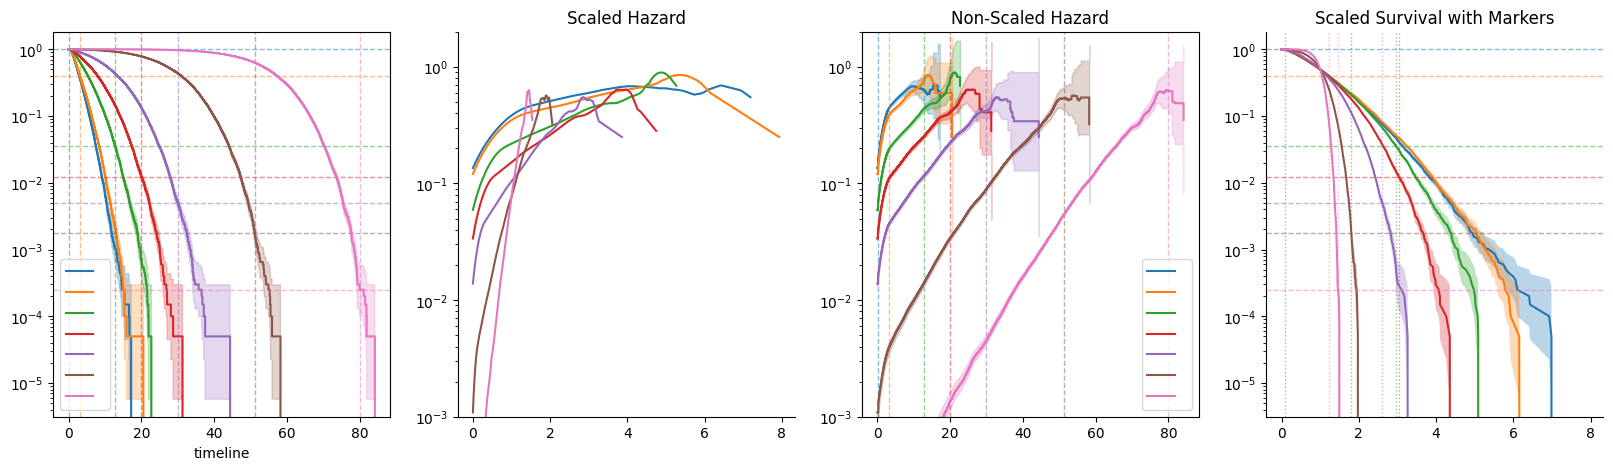

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Adjusted to have 4 panels
for sim in srs:
    sim.plotSurvival(ax=axs[0], label='')
    sim.plotScaledHazard(ax=axs[1], clean_plot=False)
    sim.plotHazard(ax=axs[2], label='')
    sim.plotScaledSurvival(ax=axs[3], label='')  # Scaled survival in the new panel
    # Add vertical lines at beta/eta and median lifetime
    for ax in [axs[2], axs[0]]:
        ax.axvline(sim.beta / sim.eta, color=axs[2].lines[-1].get_color(), ls='--', lw=1, alpha=0.5)
    axs[3].axvline(sim.beta / sim.eta/sim.getMedianLifetime(), color=axs[3].lines[-1].get_color(), ls=':', lw=1, alpha=0.5)
    axs[3].axhline(sim.survivalAtTimes(sim.beta / sim.eta), color=axs[2].lines[-1].get_color(), ls='--', lw=1, alpha=0.5)
    axs[0].axhline(sim.survivalAtTimes(sim.beta / sim.eta), color=axs[2].lines[-1].get_color(), ls='--', lw=1, alpha=0.5)


for ax in axs[:]:
    ax.set_yscale('log')
for ax in axs[1:3]:
    ax.set_ylim(1e-3, 0.2e1)

axs[1].set_title("Scaled Hazard")
axs[2].set_title("Non-Scaled Hazard")
axs[3].set_title("Scaled Survival with Markers")  # Title for the new panel



In [4]:
#sort the dataSets and bestSims by the values
sorted_values = sorted(values.items(), key=lambda x: x[1])
sorted_dataSets = {}
sorted_bestSims = {}
sorted_time_ranges = {}
for key, value in sorted_values:
    sorted_dataSets[key] = dataSets[key]
    sorted_bestSims[key] = bestSims[key]
    sorted_time_ranges[key] = time_ranges[key]
dataSets = sorted_dataSets
bestSims = sorted_bestSims
time_ranges = sorted_time_ranges


Human_F_years
Human_M_years
Mice_F
Mice2_M
Yeast
celegance
drosophila


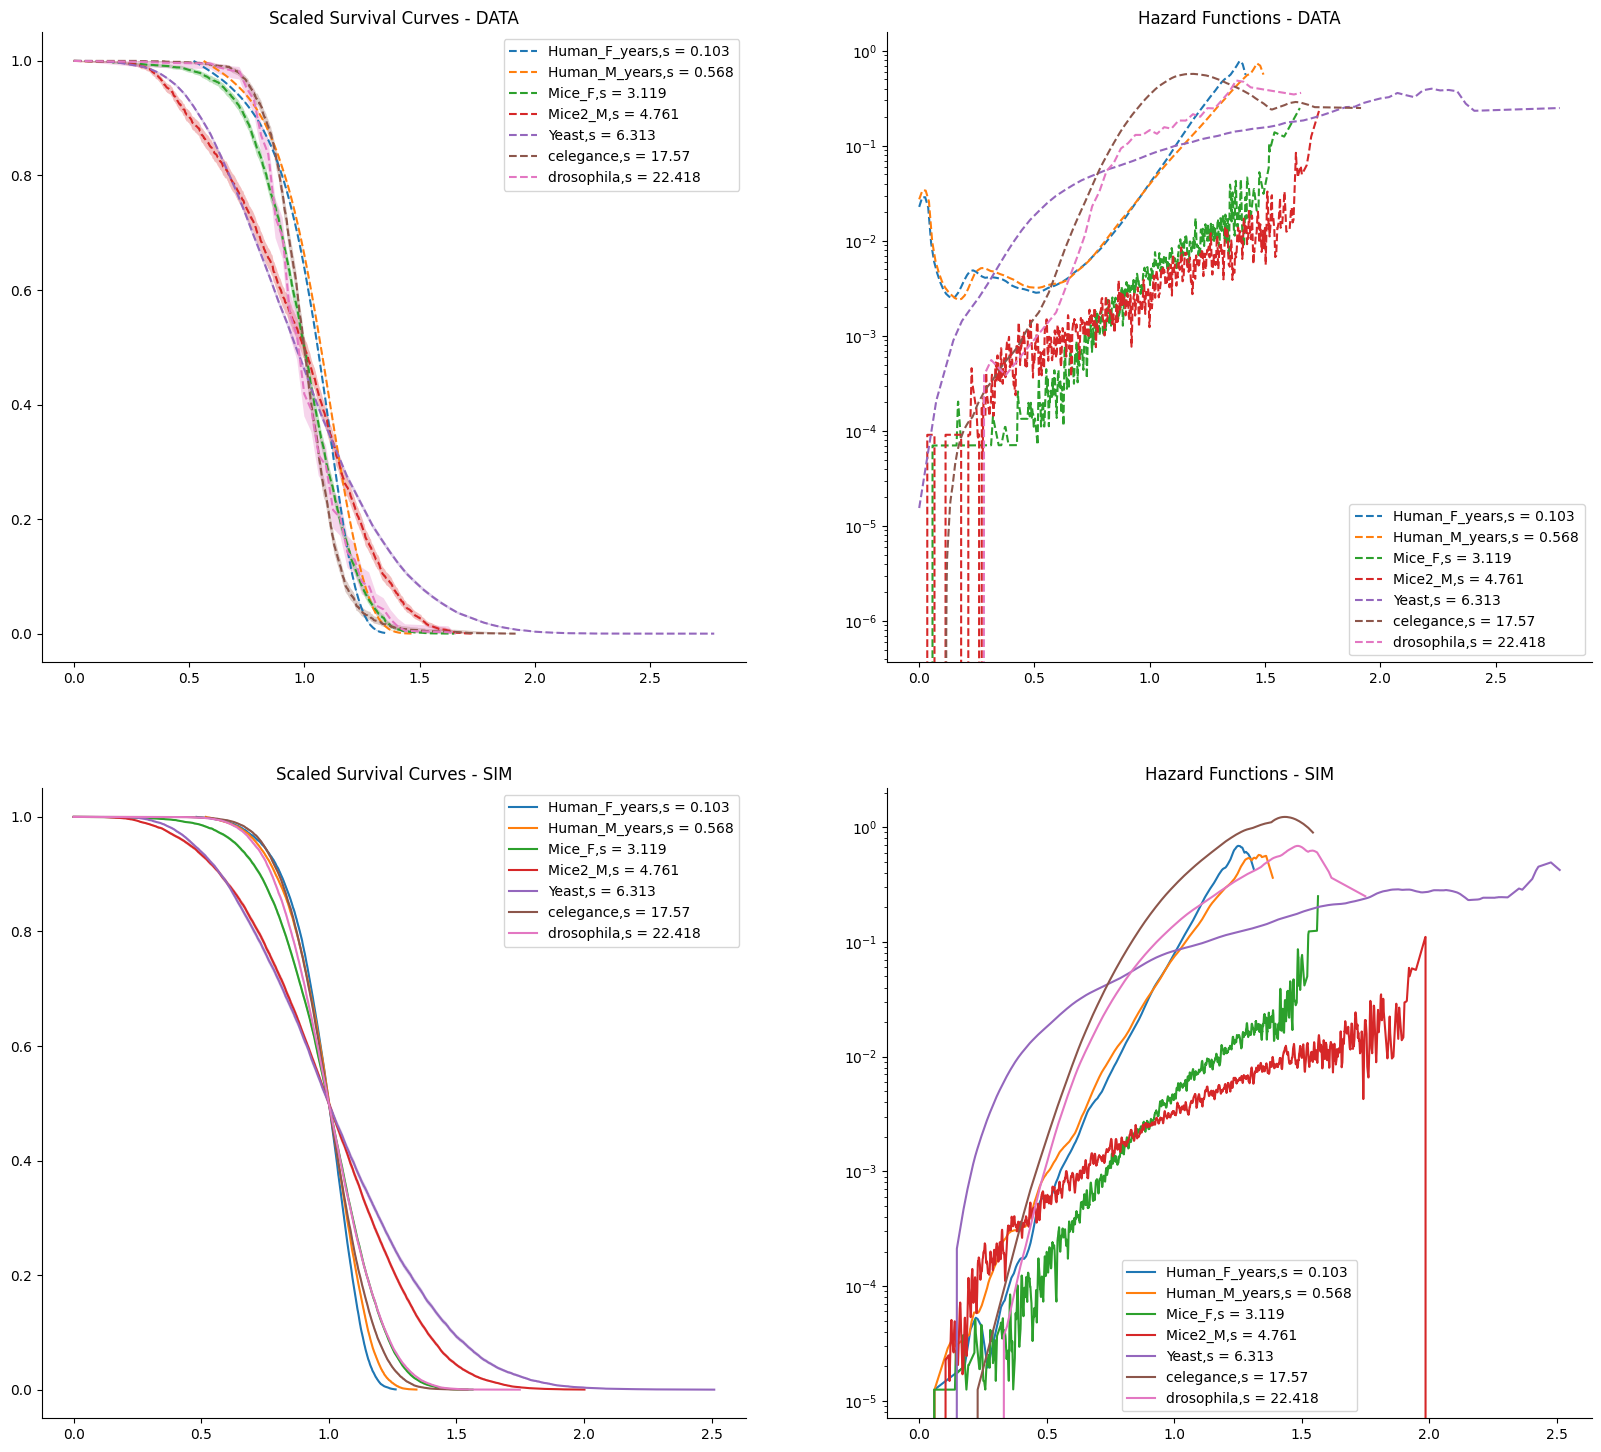

In [5]:
#plot the scaled survival curves and hazard functions for all the data sets and best simulations, labeled by the data set name
#and the value of the parameter: label = f'{key},s = {values[key]}'
fig, ax = plt.subplots(2, 2, figsize=(20, 18))
for key in dataSets:
    print(key)
    ds = dataSets[key]
    sim = bestSims[key]
    time_range = time_ranges[key]
    value = values[key]
    ds.plotScaledSurvival(ax=ax[0,0],time_range=time_range,label=f'{key},s = {value[0]}',ls='--')
    ds.plotScaledHazard(ax=ax[0,1],label=f'{key},s = {value[0]}',ls='--')
    sim.plotScaledSurvival(ax=ax[1,0],time_range=time_range,label=f'{key},s = {value[0]}')
    sim.plotScaledHazard(ax=ax[1,1],label=f'{key},s = {value[0]}')
    ax[0,1].set_yscale('log')
    ax[1,1].set_yscale('log')
    ax[0,0].set_title('Scaled Survival Curves - DATA')
    ax[0,1].set_title('Hazard Functions - DATA')
    ax[1,0].set_title('Scaled Survival Curves - SIM')
    ax[1,1].set_title('Hazard Functions - SIM')
    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

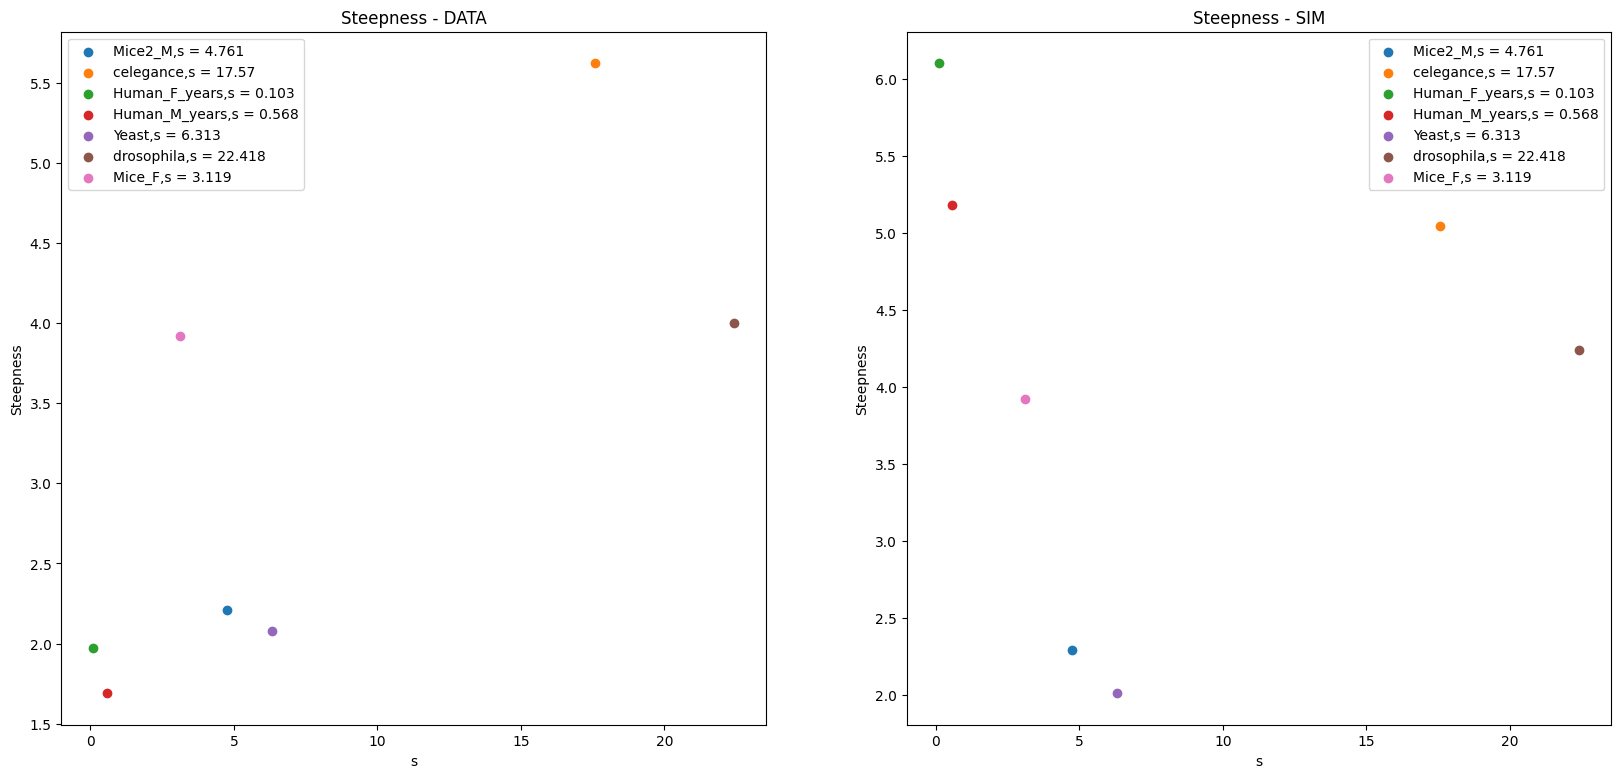

In [12]:
#plot for each data set and best simulation (on separate plots) the steepness (by getSteepness(method='AMS_Sel') vs the value of s)

fig, ax = plt.subplots(1, 2, figsize=(20, 9))
steepness_ds = {}
steepness_sim = {}
for key in dataSets:
    ds = dataSets[key]
    sim = bestSims[key]
    time_range = time_ranges[key]
    value = values[key]
    steepness_ds[key] = ds.getSteepness(method='IQR')
    steepness_sim[key] = sim.getSteepness(method='IQR')
for key in steepness_ds:
    ax[0].scatter(values[key][0],steepness_ds[key],label=f'{key},s = {values[key][0]}')
    ax[1].scatter(values[key][0],steepness_sim[key],label=f'{key},s = {values[key][0]}')
    ax[0].set_title('Steepness - DATA')
    ax[1].set_title('Steepness - SIM')
    ax[0].legend()
    ax[1].legend()
    #axis labels
    ax[0].set_xlabel('s')
    ax[1].set_xlabel('s')
    ax[0].set_ylabel('Steepness')
    ax[1].set_ylabel('Steepness')
